In [159]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show()
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(true, pred):
    print('Mean squared error: %.2f'% mean_squared_error(true, pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'% r2_score(true, pred))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(true, pred))

Cargamos los Datos y exploración inicial

In [160]:
#gdrive location:
url = 'https://raw.githubusercontent.com/pfernandez-sanofi/ml_tutorials/main/DATA/forecasting_exercise.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [161]:
df.tail()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,19,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,20,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,21,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,22,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,23,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.26,0.2727,0.65,0.1343,12,37,49


In [162]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


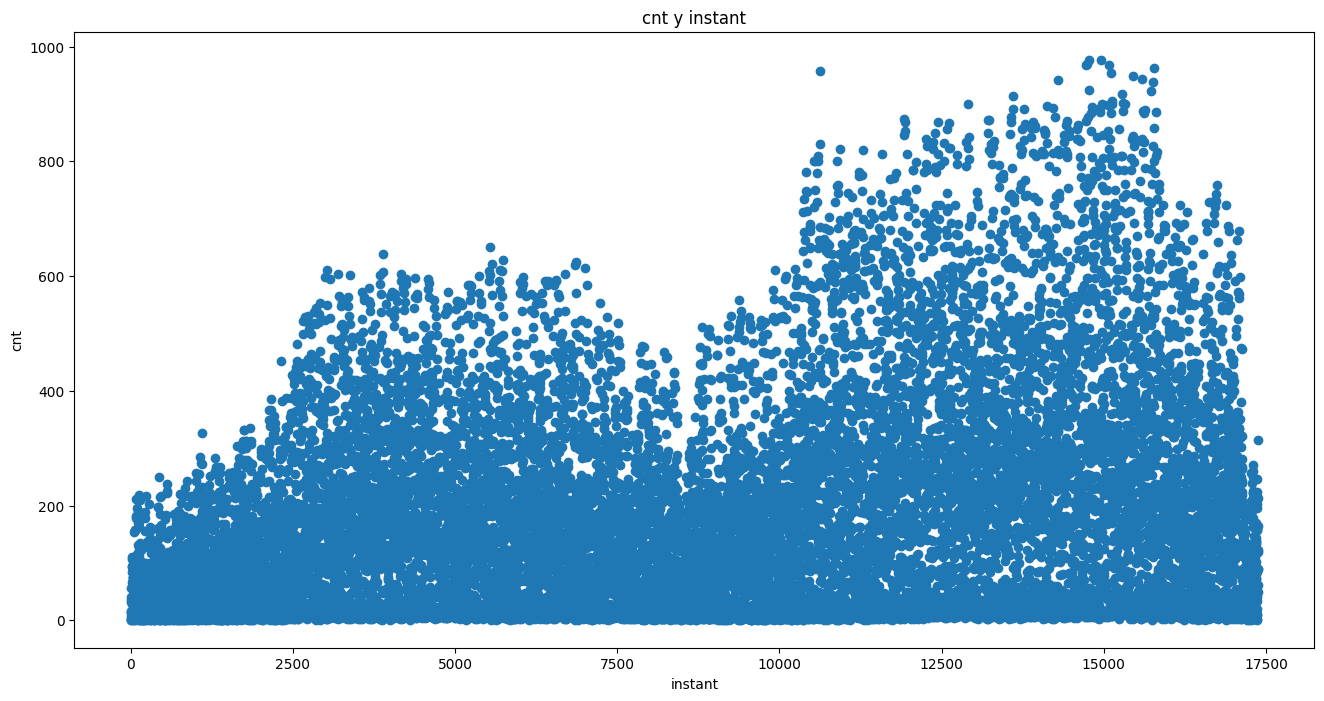

In [163]:
x = 'instant'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

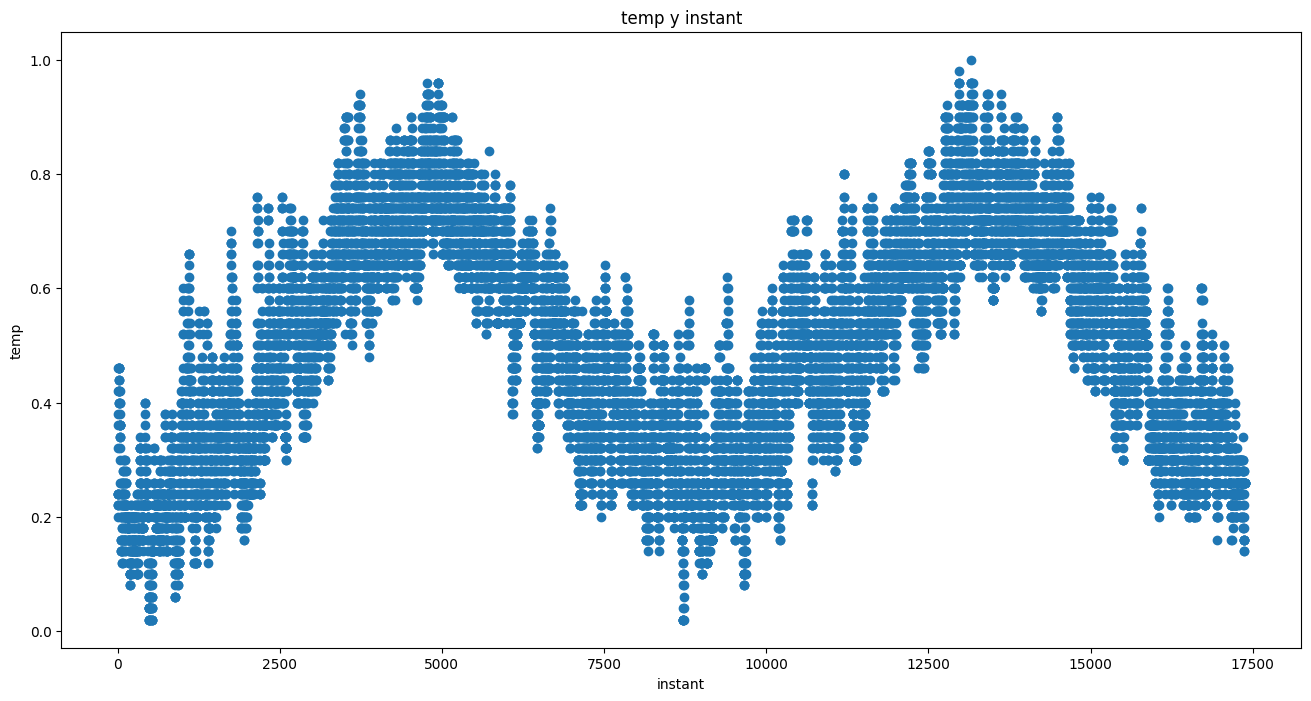

In [164]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

<AxesSubplot:>

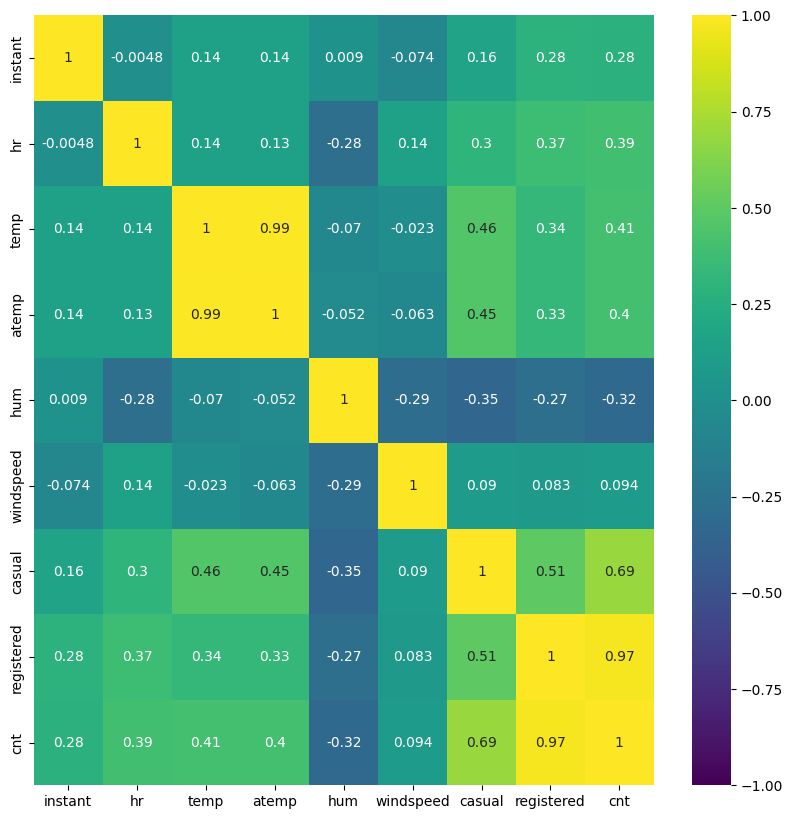

In [165]:

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

In [166]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [167]:
df_byday

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [168]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


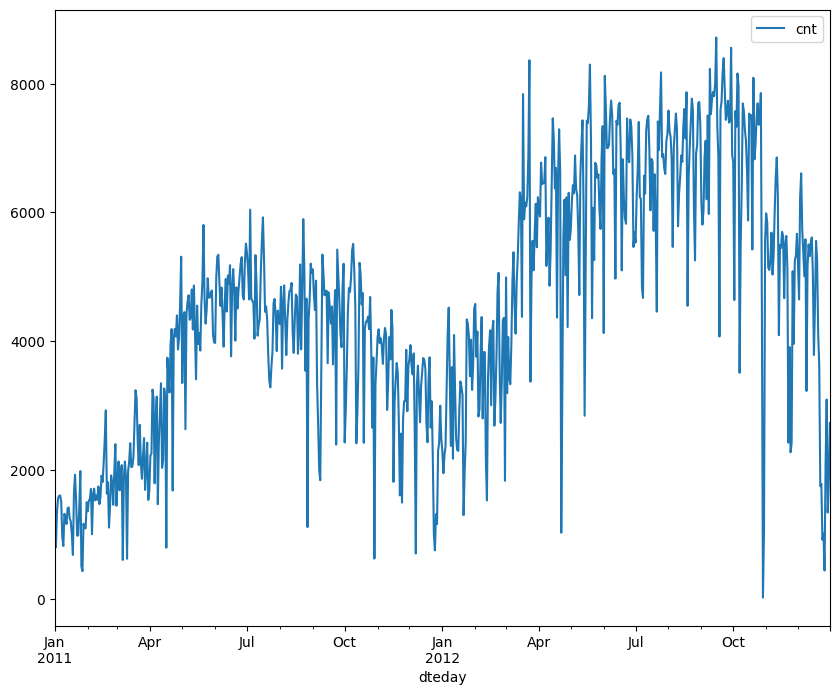

In [169]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8))
plt.show()

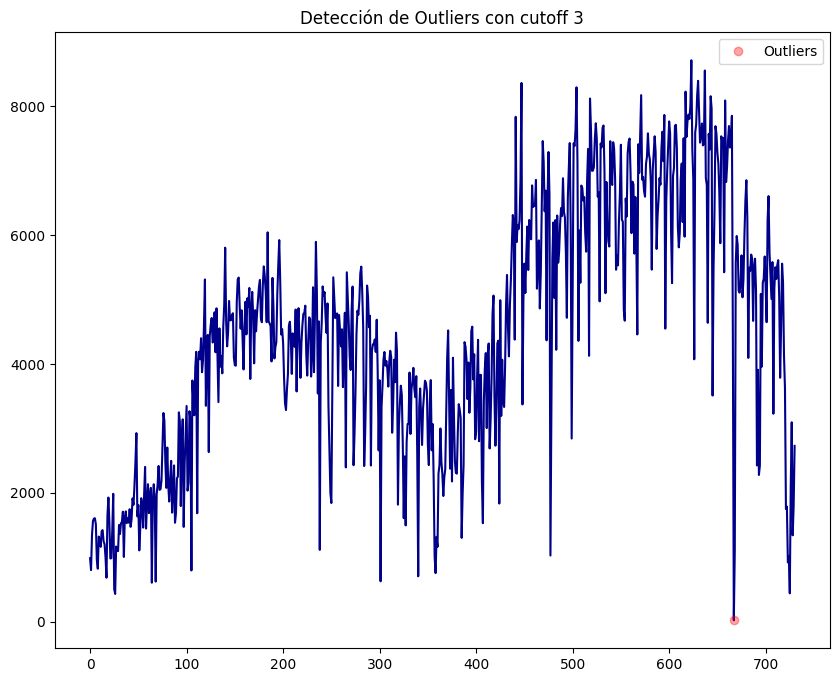

In [170]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)
plt.show()

In [171]:
df['dteday']=pd.to_datetime(df['dteday'], format='%Y-%m-%d')

In [172]:
df.isnull()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
17374,False,False,False,False,False,False,False,False,False,False,False
17375,False,False,False,False,False,False,False,False,False,False,False
17376,False,False,False,False,False,False,False,False,False,False,False
17377,False,False,False,False,False,False,False,False,False,False,False


In [173]:
df.isnull().sum()

instant         0
dteday          0
hr              0
weathersit    100
temp           99
atemp         100
hum           100
windspeed     100
casual          0
registered      0
cnt             0
dtype: int64

In [174]:
#Para las variables numéricas utilizo la media para reemplazar los nulos
df.fillna(df.mean(), inplace = True)


C:\Users\davalos\AppData\Local\Temp\ipykernel_44396\477750422.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

C:\Users\davalos\AppData\Local\Temp\ipykernel_44396\477750422.py:2: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [175]:
for column in df.columns:
        df[column].fillna(df[column].mode()[0], inplace= True)


In [176]:
df.isnull().sum()

instant       0
dteday        0
hr            0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17379 non-null  object        
 4   temp        17379 non-null  float64       
 5   atemp       17379 non-null  float64       
 6   hum         17379 non-null  float64       
 7   windspeed   17379 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB


In [178]:
print(df.head(2))

   instant     dteday  hr                                       weathersit  \
0        1 2011-01-01   0  Clear, Few clouds, Partly cloudy, Partly cloudy   
1        2 2011-01-01   1  Clear, Few clouds, Partly cloudy, Partly cloudy   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40  


In [179]:
df.head()

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,2,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,3,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,4,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,0,1,1


In [180]:
df['weathersit'].value_counts()

Clear, Few clouds, Partly cloudy, Partly cloudy                                            11445
Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                4517
Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds     1414
Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                     3
Name: weathersit, dtype: int64

In [181]:
df['weathersit']=df['weathersit'].map({'Clear, Few clouds, Partly cloudy, Partly cloudy':0,'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist':1,'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds':2,'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog':3})

In [182]:
df['weathersit'].value_counts()

0    11445
1     4517
2     1414
3        3
Name: weathersit, dtype: int64

In [183]:
dfy = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day

In [184]:
dfy= dfy.rename(columns={'dteday':'ds','cnt':'y'})

In [185]:
dfy

,ds,y
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [186]:
dfy

,ds,y
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600
...,...,...
726,2012-12-27,2114
727,2012-12-28,3095
728,2012-12-29,1341
729,2012-12-30,1796


In [187]:
# Train the models
daymodel = Prophet()
# Fit the model with train set
daymodel.fit(dfy) 


16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing


In [188]:
dayfuture = daymodel.make_future_dataframe(periods=14)
daypred = daymodel.predict(dayfuture)

In [189]:
daypred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,2390.929892,-1372.157787,1262.052130,2390.929892,2390.929892,-2399.066800,-2399.066800,-2399.066800,65.633752,65.633752,65.633752,-2464.700552,-2464.700552,-2464.700552,0.0,0.0,0.0,-8.136908
1,2011-01-02,2396.084402,-1436.902023,969.040557,2396.084402,2396.084402,-2660.760633,-2660.760633,-2660.760633,-262.002789,-262.002789,-262.002789,-2398.757844,-2398.757844,-2398.757844,0.0,0.0,0.0,-264.676231
2,2011-01-03,2401.238912,-1361.539453,1114.359108,2401.238912,2401.238912,-2483.485896,-2483.485896,-2483.485896,-158.687569,-158.687569,-158.687569,-2324.798327,-2324.798327,-2324.798327,0.0,0.0,0.0,-82.246984
3,2011-01-04,2406.393422,-1121.530143,1403.628340,2406.393422,2406.393422,-2240.910478,-2240.910478,-2240.910478,3.313015,3.313015,3.313015,-2244.223493,-2244.223493,-2244.223493,0.0,0.0,0.0,165.482944
4,2011-01-05,2411.547932,-991.106779,1484.793960,2411.547932,2411.547932,-2122.737161,-2122.737161,-2122.737161,35.780506,35.780506,35.780506,-2158.517667,-2158.517667,-2158.517667,0.0,0.0,0.0,288.810771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,2013-01-10,6508.805407,3765.572921,6115.219799,6508.689436,6509.048840,-1514.235983,-1514.235983,-1514.235983,149.134969,149.134969,149.134969,-1663.370952,-1663.370952,-1663.370952,0.0,0.0,0.0,4994.569424
741,2013-01-11,6513.387849,3804.221292,6317.518272,6513.193493,6513.685781,-1413.753817,-1413.753817,-1413.753817,166.828115,166.828115,166.828115,-1580.581932,-1580.581932,-1580.581932,0.0,0.0,0.0,5099.634032
742,2013-01-12,6517.970291,3849.340572,6311.902618,6517.739274,6518.331850,-1437.398914,-1437.398914,-1437.398914,65.633752,65.633752,65.633752,-1503.032666,-1503.032666,-1503.032666,0.0,0.0,0.0,5080.571377
743,2013-01-13,6522.552733,3536.738499,6079.470406,6522.256911,6523.003055,-1693.617052,-1693.617052,-1693.617052,-262.002789,-262.002789,-262.002789,-1431.614263,-1431.614263,-1431.614263,0.0,0.0,0.0,4828.935681


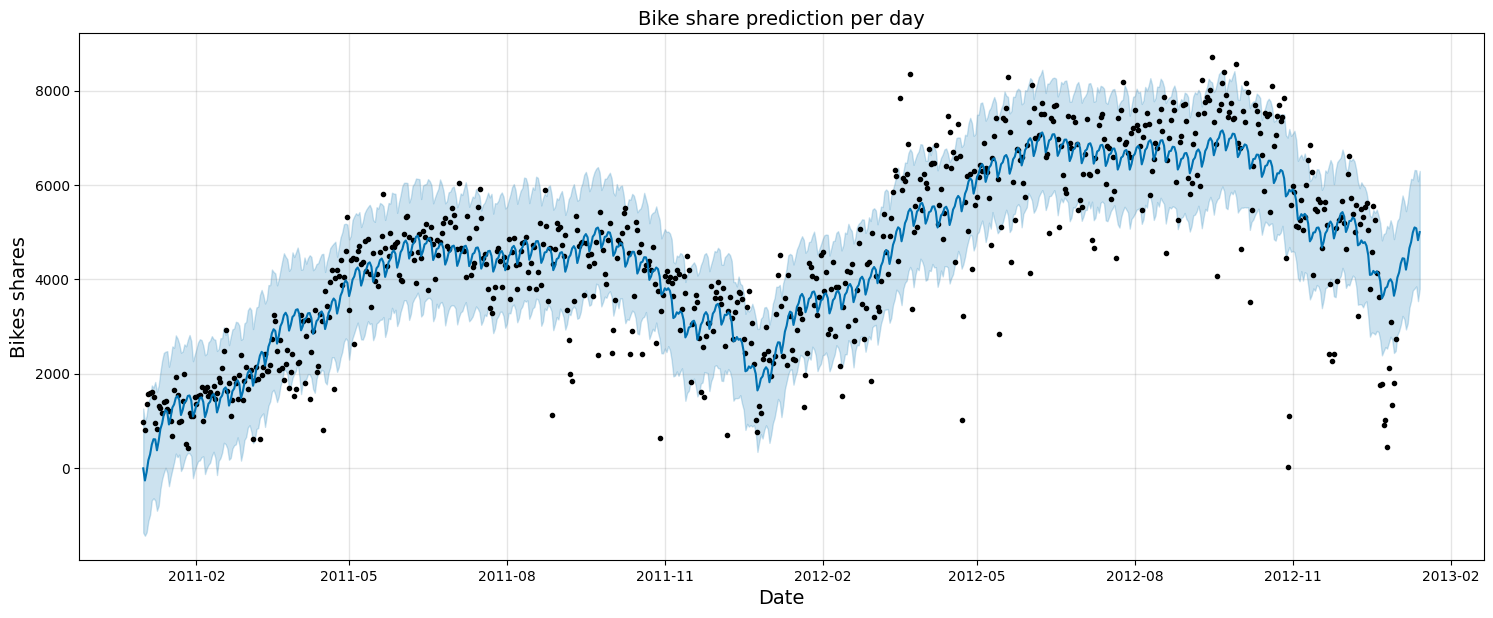

In [190]:
# Plot the day forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

daymodel.plot(daypred, ax=ax)

ax.set_title('Bike share prediction per day', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Bikes shares', fontsize=14)

plt.show()

In [191]:
# Realizamos el forecast
#forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [192]:
#fig1 = m.plot(daypred)

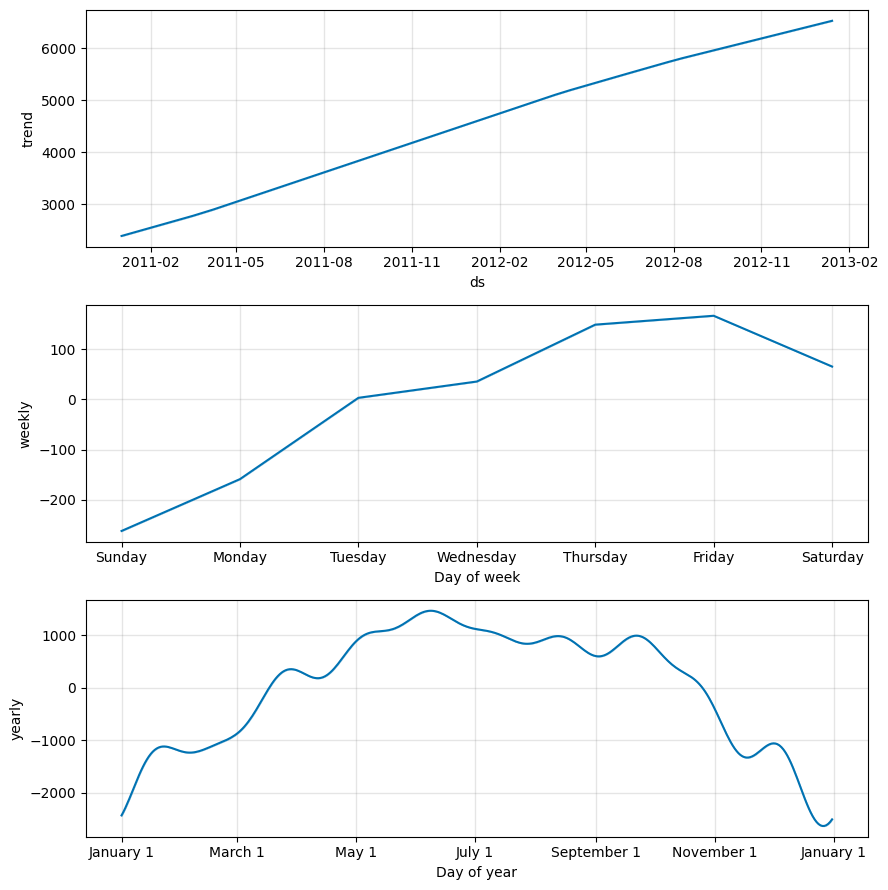

In [193]:
fig2 = daymodel.plot_components(daypred)

In [194]:
df

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,0,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,2,0,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,3,0,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,4,0,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,19,1,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,20,1,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,21,0,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,22,0,0.26,0.2727,0.56,0.1343,13,48,61


In [195]:
X = df.drop(['dteday','cnt'],axis=1)
y = df['cnt']

In [196]:
def df_split(df,train_percent):
    split_index = int(train_percent * len(df))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train,test

In [197]:
X_train,X_test = df_split(X,0.7)
y_train,y_test = df_split(y,0.7)

In [198]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

In [199]:
xgbmodel = XGBRegressor()
xgbmodel.fit(X_train,y_train)

preds = xgbmodel.predict(X_test)

In [201]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 11.232167


In [202]:
y_test.values

array([61, 36, 11, ..., 90, 61, 49], dtype=int64)

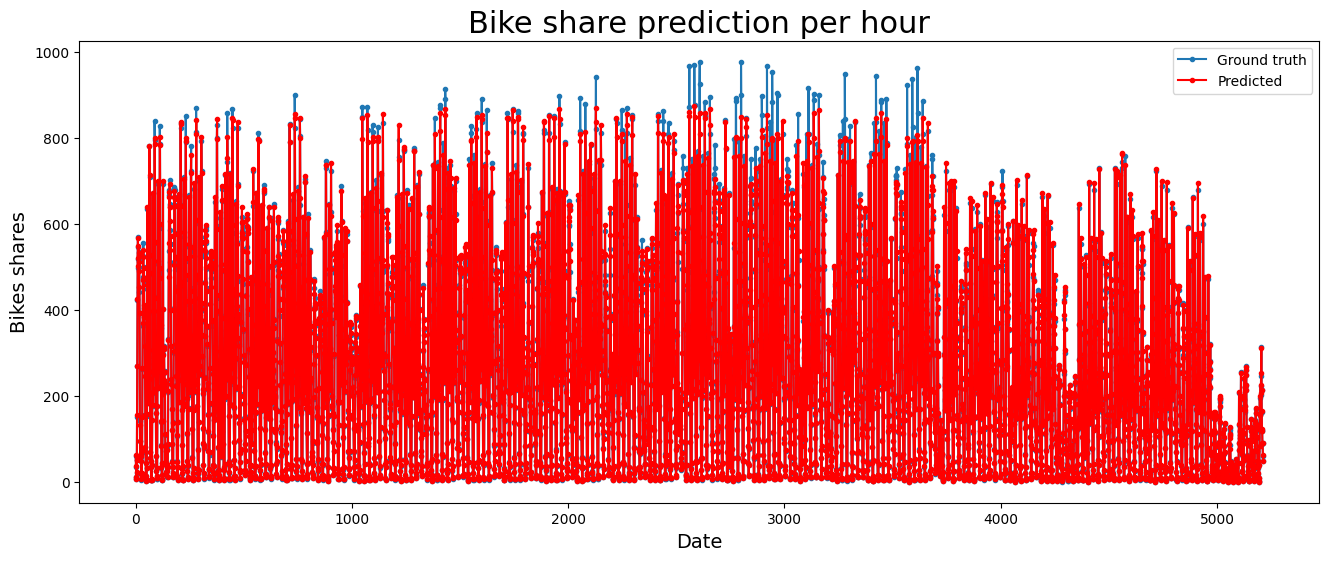

In [203]:

import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
plt.plot(y_test.values,marker=".",label="actual")
plt.plot(preds,marker=".",label="prediction",color="r")

plt.title('Bike share prediction por day', fontsize=22)
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel(ylabel='Bikes shares', fontsize=14)
plt.legend(['Ground truth', 'Predicted'])

plt.show()

In [200]:
#import plotly 

# Si tienes plotly instalado, incluso puedes realizar plots interactivos!
# Para instalar plotly simplemente utiliza pip install plotly
#from prophet.plot import plot_plotly

#plot_plotly(m, forecast)